In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform
import warnings

# seaborn 사용하기
import seaborn as sns

plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

warnings.filterwarnings('ignore')

### 상권의 서비스별의 데이터가 너무없다.
### 그래서 상권추천으로 변경하려고 한다.
### 그것을 하기 위해서 target을 만들어야 된다.
### target이었던 분기당 매출 금액은 한 점포당 평균 가격이다. 상권명별로 합쳐서 평균을 내면 안된다. 왜냐 점포수가 다르니까
### 그래서 일단은 점포수 랑 평균 분기당 매출 금액을 곱해서 총매출액을 구하고
### 그 후에 점포수와 총매출액을 상권별로 묶어서 다 더한다.
### 그 다음에 상권의 총 점포수로 나누었다.

$$ 상권평균분기매출액 = \frac {\Sigma {상권서비스별평균분기매출액}*{상권서비스별점포수}} {상권의총점포수}$$

In [80]:
data = pd.read_csv('./Data/second_target.csv')

In [81]:
data.head()

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,시군구코드,시군구명,행정동_코드,행정동_코드_명,상권_코드,상권_코드_명,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2021,1,A,골목상권,11110,종로구,11110600,가회동,1000001,계동길,...,204,6283,4828,402,2286,2963,2673,1717,1068,16
1,2021,1,A,골목상권,11110,종로구,11110600,가회동,1000001,계동길,...,11,825,1041,243,629,307,322,269,97,1
2,2021,1,A,골목상권,11110,종로구,11110600,가회동,1000001,계동길,...,136,519,635,0,185,339,242,279,112,2
3,2021,1,A,골목상권,11110,종로구,11110600,가회동,1000001,계동길,...,66,1778,2175,31,1505,1155,439,566,256,3
4,2021,1,A,골목상권,11110,종로구,11110600,가회동,1000001,계동길,...,676,7523,9187,208,2471,4577,3857,2990,2609,4


In [82]:
data['서비스_업종_코드_명'].unique()
food=data.loc[data['서비스_업종_코드_명'].isin(['한식음식점', '중식음식점', '일식음식점', '양식음식점',
                                         '제과점', '패스트푸드점', '분식전문점','커피-음료', '호프-간이주점','치킨전문점']),:]
service=data.loc[data['서비스_업종_코드_명'].isin(['일반교습학원', '한의원', '미용실', '편의점', '여관','반찬가게','철물점',
                                            '자동차수리', '여행사','고시원','독서실', '애완동물', '외국어학원',
       '볼링장','일반의원', '피부관리실', '법무사사무소','운동/경기용품', 'PC방',
       '골프연습장', '변호사사무소', '가전제품수리',
       '세무사사무소', '예술학원', '한복점', '회계사사무소', '통신기기수리', '비디오/서적임대', '자동차미용','건축물청소','전자게임장']),:]
sell=data.loc[data['서비스_업종_코드_명'].isin(['슈퍼마켓' '가방',
       '시계및귀금속', '신발', '완구', '사진관', '가구', '예술품', '섬유제품','문구', '부동산중개업',
         '서적', '화장품', '청과상','조명용품', '유아의류','인테리어', '의약품', '육류판매','스포츠 강습', '치과의원', '당구장', '세탁소',
       '노래방','안경', '화초','핸드폰', '전자상거래업', '악기','네일숍', '스포츠클럽', '의료기기',
       '가전제품','주유소', '미곡판매','컴퓨터및주변장치판매', '자전거 및 기타운송장비', '수산물판매','자동차부품', '중고차판매']),:]

In [83]:
food.columns

Index(['기준_년_코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명', '시군구코드', '시군구명',
       '행정동_코드', '행정동_코드_명', '상권_코드', '상권_코드_명', '서비스_업종_코드', '서비스_업종_코드_명',
       '분기당_매출_금액', '분기당_매출_건수', '주중_매출_비율', '주말_매출_비율', '월요일_매출_비율',
       '화요일_매출_비율', '수요일_매출_비율', '목요일_매출_비율', '금요일_매출_비율', '토요일_매출_비율',
       '일요일_매출_비율', '시간대_00~06_매출_비율', '시간대_06~11_매출_비율', '시간대_11~14_매출_비율',
       '시간대_14~17_매출_비율', '시간대_17~21_매출_비율', '시간대_21~24_매출_비율', '남성_매출_비율',
       '여성_매출_비율', '연령대_10_매출_비율', '연령대_20_매출_비율', '연령대_30_매출_비율',
       '연령대_40_매출_비율', '연령대_50_매출_비율', '연령대_60_이상_매출_비율', '주중_매출_금액',
       '주말_매출_금액', '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액',
       '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액', '시간대_00~06_매출_금액',
       '시간대_06~11_매출_금액', '시간대_11~14_매출_금액', '시간대_14~17_매출_금액',
       '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액', '여성_매출_금액',
       '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액',
       '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수', '주말_매출_건수', '월요일_매출_건수',

In [84]:
food['총매출액'] = food['점포수'] * food['분기당_매출_금액']
service['총매출액'] = service['점포수'] * service['분기당_매출_금액']
sell['총매출액'] = sell['점포수'] * sell['분기당_매출_금액']

In [85]:
# ftable=food.pivot_table(index=['기준_년_코드', '기준_분기_코드',[ '상권_구분_코드', '상권_구분_코드_명']],values=['점포수','총매출액'],aggfunc=np.sum)
# svtable=service.pivot_table(index=['기준_년_코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명'],values=['점포수','총매출액'],aggfunc=np.sum)
# sltable=sell.pivot_table(index=['기준_년_코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명'],values=['점포수','총매출액'],aggfunc=np.sum)

ftable=food.pivot_table(index=['기준_년_코드', '기준_분기_코드'],values=['점포수','총매출액'],aggfunc=np.sum)
svtable=service.pivot_table(index=['기준_년_코드', '기준_분기_코드'],values=['점포수','총매출액'],aggfunc=np.sum)
sltable=sell.pivot_table(index=['기준_년_코드', '기준_분기_코드'],values=['점포수','총매출액'],aggfunc=np.sum)

In [86]:
ftable.reset_index(inplace=True)
svtable.reset_index(inplace=True)
sltable.reset_index(inplace=True)

In [87]:
# ftable=ftable[ftable['상권_구분_코드'] == 'A']
# svtable=svtable[svtable['상권_구분_코드'] == 'A']
# sltable=sltable[sltable['상권_구분_코드'] == 'A']

In [88]:
# ftable.reset_index(inplace=True)
# svtable.reset_index(inplace=True)
# sltable.reset_index(inplace=True)

In [89]:
ftable['매출액'] = ftable['총매출액'] / ftable['점포수']
svtable['매출액'] = svtable['총매출액'] / svtable['점포수']
sltable['매출액'] = sltable['총매출액'] / sltable['점포수']

In [90]:
ftable['년+분기'] = ftable['기준_년_코드'].astype('str') + '-' + ftable['기준_분기_코드'].astype('str')
svtable['년+분기'] = svtable['기준_년_코드'].astype('str') + svtable['기준_분기_코드'].astype('str')
sltable['년+분기'] = sltable['기준_년_코드'].astype('str') + sltable['기준_분기_코드'].astype('str')
ftable.rename(
    index=ftable['년+분기'],
    inplace=True
)

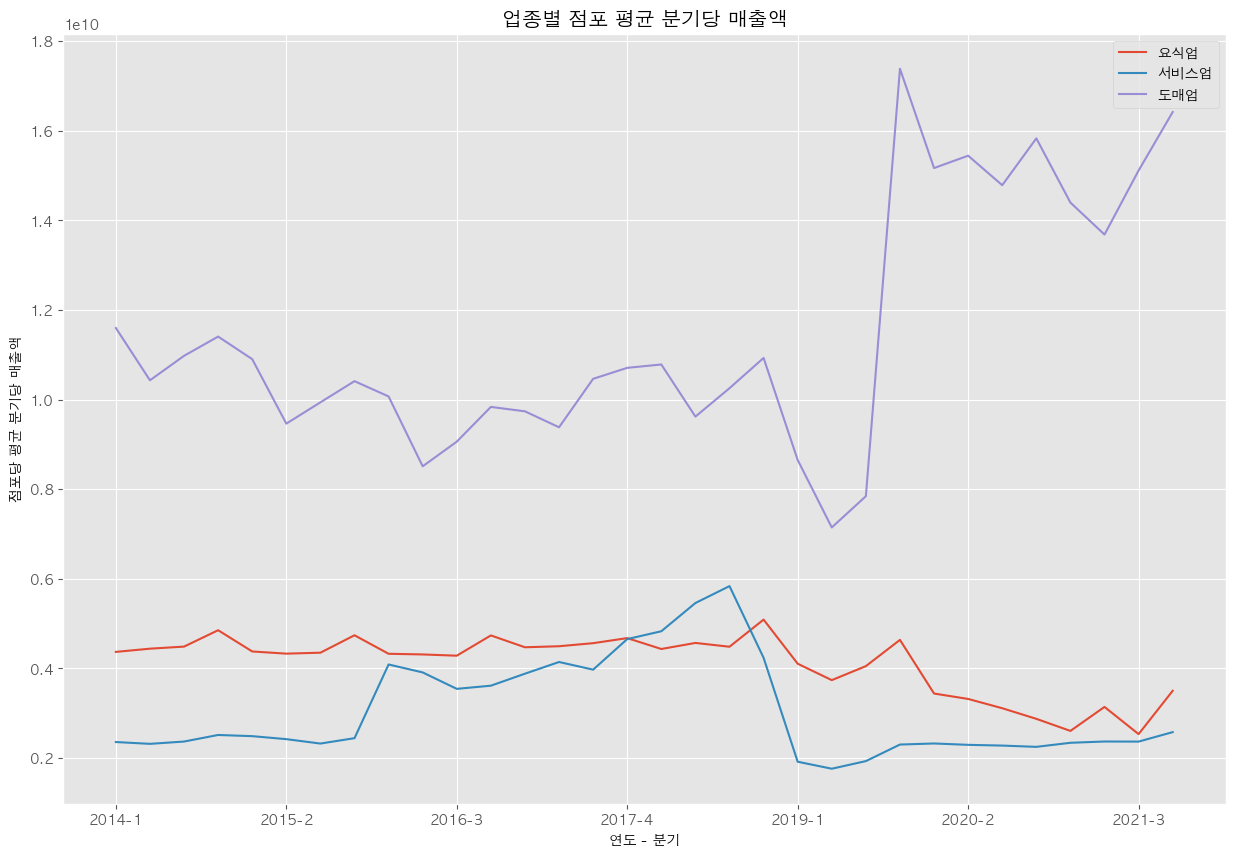

In [91]:
plt.style.use('ggplot')

plt.figure(figsize=(15,10))

ftable['매출액'].plot(
    label='요식업',
    legend=True
)
svtable['매출액'].plot(
    label='서비스업',
    legend=True
)
sltable['매출액'].plot(
    label='도매업',
    legend=True
)

plt.xlabel('연도 - 분기')
plt.ylabel('점포당 평균 분기당 매출액')

plt.title('업종별 점포 평균 분기당 매출액')

plt.show()

In [92]:
data['상권_구분_코드_명'].unique()

array(['골목상권', '발달상권', '전통시장', '관광특구'], dtype=object)

In [93]:
data['서비스_업종_코드_명'].unique()

array(['한식음식점', '중식음식점', '일식음식점', '양식음식점', '제과점', '패스트푸드점', '분식전문점',
       '커피-음료', '일반교습학원', '한의원', '미용실', '슈퍼마켓', '편의점', '일반의류', '가방',
       '시계및귀금속', '신발', '완구', '호프-간이주점', '사진관', '가구', '예술품', '섬유제품',
       '치킨전문점', '문구', '부동산중개업', '서적', '화장품', '청과상', '여관', '조명용품', '유아의류',
       '반찬가게', '인테리어', '의약품', '육류판매', '스포츠 강습', '치과의원', '당구장', '세탁소',
       '노래방', '안경', '화초', '철물점', '자동차수리', '여행사', '핸드폰', '전자상거래업', '악기',
       '네일숍', '스포츠클럽', '의료기기', '고시원', '가전제품', '독서실', '애완동물', '외국어학원',
       '볼링장', '주유소', '미곡판매', '일반의원', '피부관리실', '법무사사무소', '운동/경기용품', 'PC방',
       '골프연습장', '컴퓨터및주변장치판매', '자전거 및 기타운송장비', '변호사사무소', '가전제품수리',
       '세무사사무소', '예술학원', '한복점', '회계사사무소', '통신기기수리', '비디오/서적임대', '자동차미용',
       '수산물판매', '자동차부품', '건축물청소', '중고차판매', '전자게임장'], dtype=object)

In [94]:
food=data[data['서비스_업종_코드_명'].isin(
       ['한식음식점', '중식음식점', '일식음식점', '양식음식점',
          '패스트푸드점', '분식전문점',
          '치킨전문점','제과점','호프-간이주점','커피-음료'])]

In [95]:
food.to_csv('./Data/food_0217.csv',index=False)

In [96]:
food.iloc[:5,:13]

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,시군구코드,시군구명,행정동_코드,행정동_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,분기당_매출_금액
0,2021,1,A,골목상권,11110,종로구,11110600,가회동,1000001,계동길,CS100001,한식음식점,316763168
1,2021,1,A,골목상권,11110,종로구,11110600,가회동,1000001,계동길,CS100002,중식음식점,39791852
2,2021,1,A,골목상권,11110,종로구,11110600,가회동,1000001,계동길,CS100003,일식음식점,60325474
3,2021,1,A,골목상권,11110,종로구,11110600,가회동,1000001,계동길,CS100004,양식음식점,199448496
4,2021,1,A,골목상권,11110,종로구,11110600,가회동,1000001,계동길,CS100005,제과점,165688274


In [97]:
food.columns

Index(['기준_년_코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명', '시군구코드', '시군구명',
       '행정동_코드', '행정동_코드_명', '상권_코드', '상권_코드_명', '서비스_업종_코드', '서비스_업종_코드_명',
       '분기당_매출_금액', '분기당_매출_건수', '주중_매출_비율', '주말_매출_비율', '월요일_매출_비율',
       '화요일_매출_비율', '수요일_매출_비율', '목요일_매출_비율', '금요일_매출_비율', '토요일_매출_비율',
       '일요일_매출_비율', '시간대_00~06_매출_비율', '시간대_06~11_매출_비율', '시간대_11~14_매출_비율',
       '시간대_14~17_매출_비율', '시간대_17~21_매출_비율', '시간대_21~24_매출_비율', '남성_매출_비율',
       '여성_매출_비율', '연령대_10_매출_비율', '연령대_20_매출_비율', '연령대_30_매출_비율',
       '연령대_40_매출_비율', '연령대_50_매출_비율', '연령대_60_이상_매출_비율', '주중_매출_금액',
       '주말_매출_금액', '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액',
       '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액', '시간대_00~06_매출_금액',
       '시간대_06~11_매출_금액', '시간대_11~14_매출_금액', '시간대_14~17_매출_금액',
       '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액', '여성_매출_금액',
       '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액',
       '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수', '주말_매출_건수', '월요일_매출_건수',

In [98]:
# 총 매출액을 구하자 일단
food = food[food['점포수'] != 0]

In [99]:
food['총매출액'] = food['분기당_매출_금액'] * food['점포수']

In [100]:
food[['총매출액','점포수']]

,총매출액,점포수
0,5068210688,16
1,39791852,1
2,120650948,2
3,598345488,3
4,662753096,4
...,...,...
1218631,6719734738,17
1218632,161221185,3
1218633,205365380,4
1218634,728860130,5


In [101]:
food_sangkwon_target_0217=food.pivot_table(
    index=['기준_년_코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명', '시군구코드', '시군구명',
       '행정동_코드', '행정동_코드_명', '상권_코드', '상권_코드_명'],
    values=['총매출액','점포수'],
    aggfunc=np.sum
    )

In [102]:
food_sangkwon_target_0217['점포매출액'] = \
food_sangkwon_target_0217['총매출액'] / food_sangkwon_target_0217['점포수']

In [103]:
food_sangkwon_target2_0217=food.pivot_table(
    index=['기준_년_코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명', '시군구코드', '시군구명',
       '행정동_코드', '행정동_코드_명', '상권_코드', '상권_코드_명'],
    values=['분기당_매출_금액'],
    aggfunc=np.mean
    )

In [104]:
food_sangkwon_target_0217.head()

점포수  \
기준_년_코드 기준_분기_코드 상권_구분_코드 상권_구분_코드_명 시군구코드 시군구명 행정동_코드   행정동_코드_명 상권_코드   상권_코드_명        
2014    1        A        골목상권       11110 종로구  11110515 청운효자동    1000012 옥인길       17   
                                                11110530 사직동      1000016 자하문로7길    60   
                                                                  1000027 필운대로1길    29   
                                                11110540 삼청동      1000007 북촌로5길     88   
                                                                  1000008 북촌로5나길    58   

                                                                                           총매출액  \
기준_년_코드 기준_분기_코드 상권_구분_코드 상권_구분_코드_명 시군구코드 시군구명 행정동_코드   행정동_코드_명 상권_코드   상권_코드_명                 
2014    1        A        골목상권       11110 종로구  11110515 청운효자동    1000012 옥인길        1678722741   
                                                11110530 사직동      1000016 자하문로7길    34115456247   
                                                                  1000027 필운대로1길     5736954304   
                                                11110540 삼청동      1000007 북촌로5길    116149167487   
                                                                  1000008 북촌로5나길    92170452126   

                                                                                          점포매출액  
기준_년_코드 기준_분기_코드 상권_구분_코드 상권_구분_코드_명 시군구코드 시군구명 행정동_코드   행정동_코드_명 상권_코드   상권_코드_명                
2014    1        A        골목상권       11110 종로구  11110515 청운효자동    1000012 옥인길      9.874840e+07  
                                                11110530 사직동      1000016 자하문로7길   5.685909e+08  
                                                                  1000027 필운대로1길   1.978260e+08  
                                                11110540 삼청동      1000007 북촌로5길    1.319877e+09  
                                                                  1000008 북촌로5나길   1.589146e+09

In [105]:
# 타겟 완성
target = food_sangkwon_target_0217.reset_index()

In [106]:
target.to_csv('./Data2/target.csv',index=False)

### 나머지 피쳐들을 정리하자


### 비율관련

In [107]:
ratio=food[['기준_년_코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명', '시군구코드', '시군구명',
       '행정동_코드', '행정동_코드_명', '상권_코드', '상권_코드_명','주중_매출_비율', '주말_매출_비율', '월요일_매출_비율',
       '화요일_매출_비율', '수요일_매출_비율', '목요일_매출_비율', '금요일_매출_비율', '토요일_매출_비율',
       '일요일_매출_비율', '시간대_00~06_매출_비율', '시간대_06~11_매출_비율', '시간대_11~14_매출_비율',
       '시간대_14~17_매출_비율', '시간대_17~21_매출_비율', '시간대_21~24_매출_비율', '남성_매출_비율',
       '여성_매출_비율', '연령대_10_매출_비율', '연령대_20_매출_비율', '연령대_30_매출_비율',
       '연령대_40_매출_비율', '연령대_50_매출_비율', '연령대_60_이상_매출_비율']]

In [108]:
ratio.head()

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,시군구코드,시군구명,행정동_코드,행정동_코드_명,상권_코드,상권_코드_명,...,시간대_17~21_매출_비율,시간대_21~24_매출_비율,남성_매출_비율,여성_매출_비율,연령대_10_매출_비율,연령대_20_매출_비율,연령대_30_매출_비율,연령대_40_매출_비율,연령대_50_매출_비율,연령대_60_이상_매출_비율
0,2021,1,A,골목상권,11110,종로구,11110600,가회동,1000001,계동길,...,38,3,45,32,1,15,20,18,15,9
1,2021,1,A,골목상권,11110,종로구,11110600,가회동,1000001,계동길,...,35,1,39,49,10,33,15,13,12,5
2,2021,1,A,골목상권,11110,종로구,11110600,가회동,1000001,계동길,...,30,25,30,36,0,8,19,16,16,7
3,2021,1,A,골목상권,11110,종로구,11110600,가회동,1000001,계동길,...,48,2,40,43,0,28,25,9,15,6
4,2021,1,A,골목상권,11110,종로구,11110600,가회동,1000001,계동길,...,27,4,37,45,1,11,19,18,16,17


In [109]:
from module.average import g_mean

In [110]:
ratio_sangkwon = ratio.pivot_table(
    index=['기준_년_코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명', '시군구코드', '시군구명',
       '행정동_코드', '행정동_코드_명', '상권_코드', '상권_코드_명'],
    aggfunc=g_mean
    )

In [111]:
ratio_sangkwon.fillna(0,inplace=True)

In [112]:
feature_ratio=ratio_sangkwon.reset_index()

In [113]:
feature_ratio.to_csv('./Data2/feature_ratio.csv',index=False)